In [5]:
#!/usr/bin/env python
# coding: utf-8

import glob
import re
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="pastel", color_codes=True, font='Helvetica')

# Set font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIG_SIZE = 10

plt.rcParams.update({
    'legend.loc': 'center left',
    'font.family': 'Helvetica',
    'pdf.fonttype': 42,
    'font.size': BIG_SIZE,         # controls default text sizes
    'axes.titlesize': SMALL_SIZE,  # fontsize of the axes title
    'axes.labelsize': MEDIUM_SIZE, # fontsize of the x and y labels
    'xtick.labelsize': SMALL_SIZE, # fontsize of the tick labels
    'ytick.labelsize': SMALL_SIZE, # fontsize of the tick labels
    'legend.fontsize': SMALL_SIZE, # legend fontsize
    'figure.titlesize': BIG_SIZE,   # fontsize of the figure title
    'figure.figsize': (6,3),
    'figure.dpi': 120
})

In [6]:
res2seq = (pd.read_csv('../data/ddg/residue_number_map.txt')
           .set_index('resnum').to_dict()['seqnum']
          )
aa1 = ['W','Y','F','M','L','I','V','A','C','G',
       'P','T','S','Q','N','E','D','H','R','K']
aa3 = ['TRP', 'TYR', 'PHE', 'MET', 'LEU',
       'ILE', 'VAL', 'ALA', 'CYS', 'GLY',
       'PRO', 'THR', 'SER', 'GLN', 'ASN',
       'GLU', 'ASP', 'HIS', 'ARG', 'LYS']
aa3to1 = dict(zip(aa3,aa1))
aa3to1['H2S'] = 'H'
aa3to1['H1S'] = 'H'

In [7]:
# read in FoldX alanine scan data

with open('../data/ddg/GSP1_Repair_AS.fxout', 'r') as f:
    lines = f.readlines()
    
    dfs = []
    
    for i, l in enumerate(lines):

        s = l.rstrip().split(' ')
        
        d = {'aa_from': aa3to1[s[0]],
             'position': int(s[1]),
             'aa_to': aa3to1[s[3]],
             'ddg_foldx': np.float64(s[-1])}
        
        dfs.append(pd.DataFrame(d, index=[i]))
        
foldx = pd.concat(dfs)

rosetta = (pd.read_csv('../data/ddg/20200806_gsp1_ddg_with_scores.csv')
           [['mutation','aa_from','position','aa_to','ddg']]
           .drop_duplicates()
           .rename(columns={'ddg':'ddg_rosetta'})
          )

df = pd.merge(rosetta, foldx, on=['aa_from','position','aa_to'])
df['is_outlier'] = df.apply(lambda row: True if row.ddg_foldx - row.ddg_rosetta > 2.2 else False, axis=1)

Text(0.5, 1.0, 'Gsp1 3m1i alanine scan. Regression ignoring outliers, r^2 = 0.876')

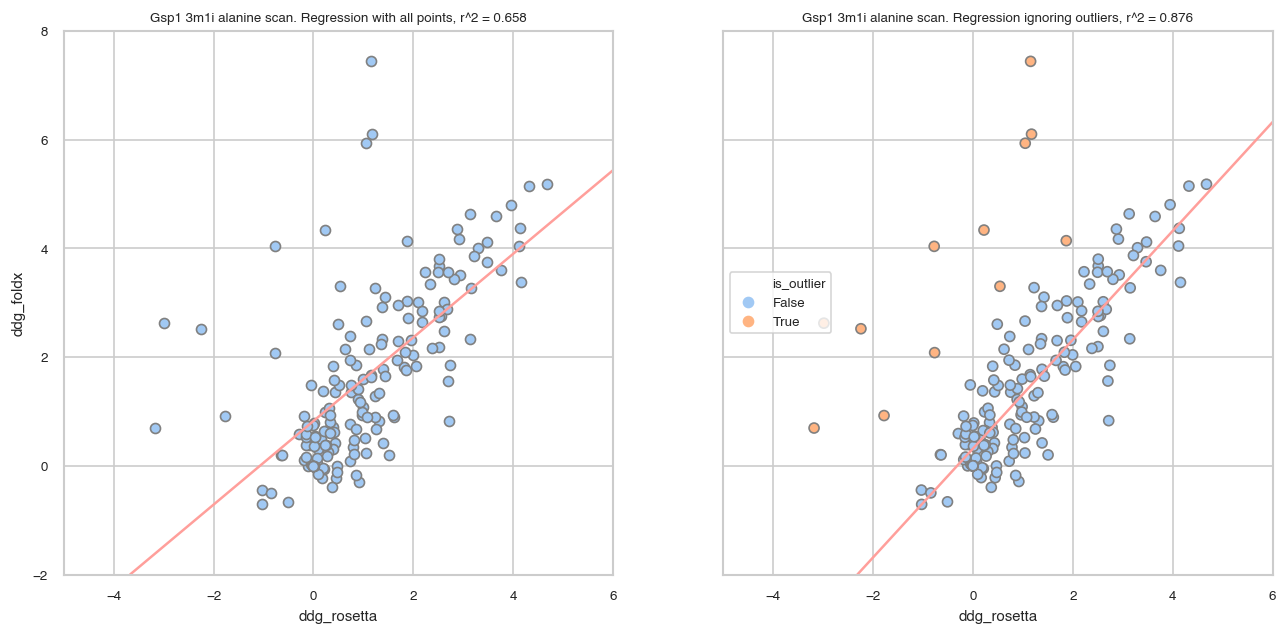

In [9]:
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (13,6))

# on the left plot, fit a regression line for all points
g1 = (sns.scatterplot(data=df, x='ddg_rosetta', y='ddg_foldx',
                     linewidth=1, edgecolor='gray', ax=ax1)
     .set(ylim=(-2,8), xlim=(-5,6))
)

lm1 = sp.stats.linregress(x=df.ddg_rosetta,
                          y=df.ddg_foldx)
ax1.axline((0, lm1.intercept), (1, lm1.slope+lm1.intercept), color='r')
ax1.set_title('Gsp1 3m1i alanine scan. Regression with all points, r^2 = {}'.format(round(lm1.rvalue, 3)))

# on the right plot, ignore the outlier points
g2 = (sns.scatterplot(data=df, x='ddg_rosetta', y='ddg_foldx',hue='is_outlier',
                      linewidth=1, edgecolor='gray', ax=ax2)
      .set(ylim=(-2,8), xlim=(-5,6))
     )

lm2 = sp.stats.linregress(x=df[df.is_outlier==False].ddg_rosetta,
                          y=df[df.is_outlier==False].ddg_foldx)
ax2.axline((0, lm2.intercept), (1, lm2.slope+lm2.intercept), color='r')
ax2.set_title('Gsp1 3m1i alanine scan. Regression ignoring outliers, r^2 = {}'.format(round(lm2.rvalue, 3)))

What are the outliers? i.e. points that FoldX over-estimates?
- Glycines
- Proline-adjacent or Proline
- T26, which corresponds to T24 Ran. This reside contacts the Mg, and T24N is the known nucleotide-binding perturbed mutant
- R78, which is next to switch II and is a known biochemically perturbed mutant for R78K
- D150: no good explanation. it's on the end of the beta sheet

In [10]:
df[df.ddg_foldx-df.ddg_rosetta > 2.2]

,mutation,aa_from,position,aa_to,ddg_rosetta,ddg_foldx,is_outlier
9,G19A,G,19,A,1.156000,7.439610,True
16,T26A,T,26,A,0.222308,4.336350,True
36,G46A,G,46,A,0.541764,3.301600,True
60,G70A,G,70,A,1.174060,6.100530,True
66,G76A,G,76,A,1.048190,5.933390,True
68,R78A,R,78,A,-1.778110,0.923870,True
93,V103A,V,103,A,-0.765562,2.081610,True
94,P104A,P,104,A,-2.240660,2.520870,True
113,G123A,G,123,A,-0.774204,4.036490,True
140,D150A,D,150,A,1.869350,4.140740,True


Now plot fitness vs ddg, with foldx and rosetta as different colors

show the regression lines?

In [11]:
fitness_df = (
    pd.merge(pd.read_csv('../data/fitness/15gen_binned_0607.csv'), df)
    .melt(id_vars=('mutation','score'), value_vars=('ddg_rosetta','ddg_foldx'),
          var_name='ddg_type', value_name='ddg')
    .assign(ddg_type=lambda df: df.ddg_type.apply(lambda row: row[4:]))
    .rename({'score':'fitness', 'mutant':'mutation'}, axis='columns')
)
fitness_df.head()

,mutation,fitness,ddg_type,ddg
0,V10A,-0.795123,rosetta,-0.291027
1,P11A,0.230768,rosetta,0.234526
2,T12A,0.033037,rosetta,0.727120
3,F13A,NaN,rosetta,2.225050
4,K14A,0.286616,rosetta,1.810530


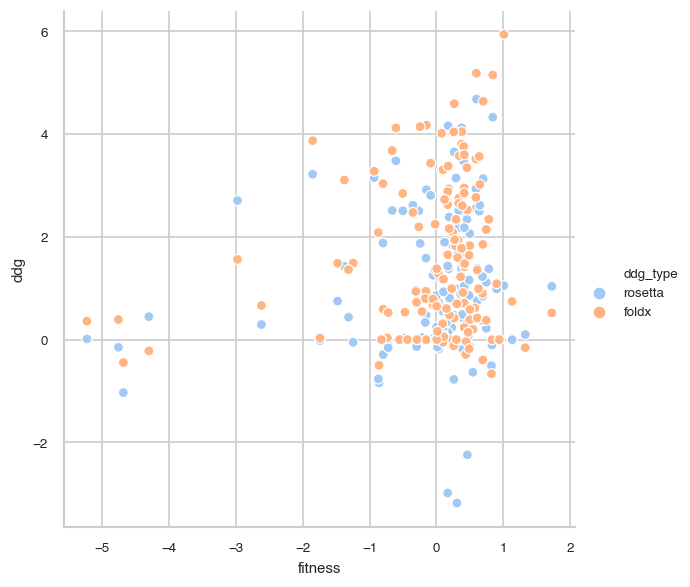

In [12]:
# fig, ax = plt.subplots()


sns.relplot(data=fitness_df, x='fitness', y='ddg', hue='ddg_type', edgecolor='gray')
# sns.scatterplot(data=fitness_df, x='fitness', y='ddg_foldx', ax=ax)

Let's see what those outliers (fitness < -2 but ddG < 3) are:

In [13]:
(fitness_df
 .loc[lambda df: df.fitness < -2]
#  .loc[lambda df: df.ddg < 1]
 .sort_values('fitness')
)

,mutation,fitness,ddg_type,ddg
90,K101A,-5.231224,rosetta,0.012218
263,K101A,-5.231224,foldx,0.358820
87,I98A,-4.758458,rosetta,-0.149894
260,I98A,-4.758458,foldx,0.388788
15,K25A,-4.684357,rosetta,-1.030900
188,K25A,-4.684357,foldx,-0.446874
72,I83A,-4.303981,rosetta,0.446642
245,I83A,-4.303981,foldx,-0.219203
27,F37A,-2.976992,rosetta,2.703160
200,F37A,-2.976992,foldx,1.558820


Wow! Several have known functional annotations that would not be captured by biophysical modeling
- Y41 is ESSENTIAL for stabilizing the closed conformation, and Y41A is a well-studied mutation. 
- F37 is F35 in Ran, and F35L is all in state 1 in Geyer 1999
- K101 is acetylated and has a role in GEF-binding (acetylation blocks GEF binding)
- K25 contacts the nucleotide and the Mg
- I98 is an interface residue with the GEF, athough it is a valine in Ran. Ile to Polar mutations in the fitness assay are strongly deleterious at that position
- I81 seems to be a conserved packing contact with karyopherins

What about the predicted Rosetta stabilizing mutations? They are karyopherin interface mutations, near or are proline:

In [14]:
(fitness_df
 .loc[lambda df: df.ddg < -2]
 .sort_values('fitness')
)

,mutation,fitness,ddg_type,ddg
151,P162A,0.170127,rosetta,-2.98256
150,K161A,0.307656,rosetta,-3.17877
93,P104A,0.464766,rosetta,-2.24066


Next, how does ddG relate to conservation and burial for these alanine mutants?

In [15]:
# load in the dataset from tina

df_consurf_burial = pd.read_csv('../data/conservation_and_SASA/consurf_and_mds_and_sasa.txt', delimiter='\t')

In [16]:
df_consurf_burial

,position,consurf_score,consurf,aa_to,score,region3,bin,sasa_group_category,score_bin,SEQ,exists_in_msa
0,1,-0.596,7,W,-5.999734,effector surface,STOP-like,surface,4,NaN,no
1,1,-0.596,7,F,-8.000000,effector surface,NaN,surface,4,M,yes
2,1,-0.596,7,Y,-3.593266,effector surface,intermediate,surface,3,NaN,no
3,1,-0.596,7,L,-4.190606,effector surface,STOP-like,surface,4,M,yes
4,1,-0.596,7,I,-5.481027,effector surface,STOP-like,surface,4,NaN,no
...,...,...,...,...,...,...,...,...,...,...,...
4375,219,-0.990,8,H,-0.353337,C-terminal surface,neutral,surface,2,NaN,no
4376,219,-0.990,8,R,-0.174941,C-terminal surface,neutral,surface,2,NaN,no
4377,219,-0.990,8,K,-1.345961,C-terminal surface,intermediate,surface,3,NaN,no
4378,219,-0.990,8,D,1.058344,C-terminal surface,beneficial,surface,1,NaN,no


Does burial explain difference between foldx and rosetta?

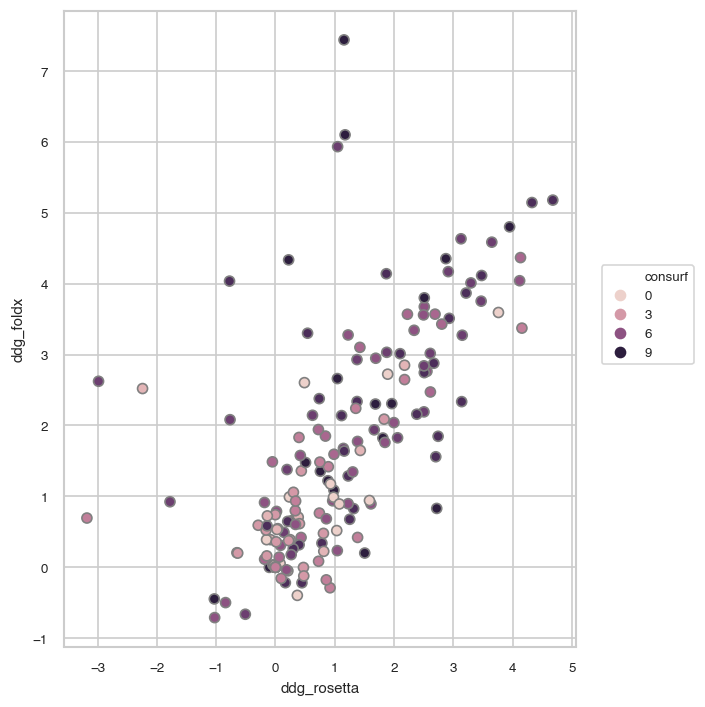

In [35]:
f, ax = plt.subplots(figsize=(6,6))

g = (pd.merge(df, df_consurf_burial)
     .pipe((sns.scatterplot, 'data'),
           x='ddg_rosetta', y='ddg_foldx',
           hue='consurf',
         linewidth=1, edgecolor='gray', ax=ax)
    )
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)
plt.tight_layout()


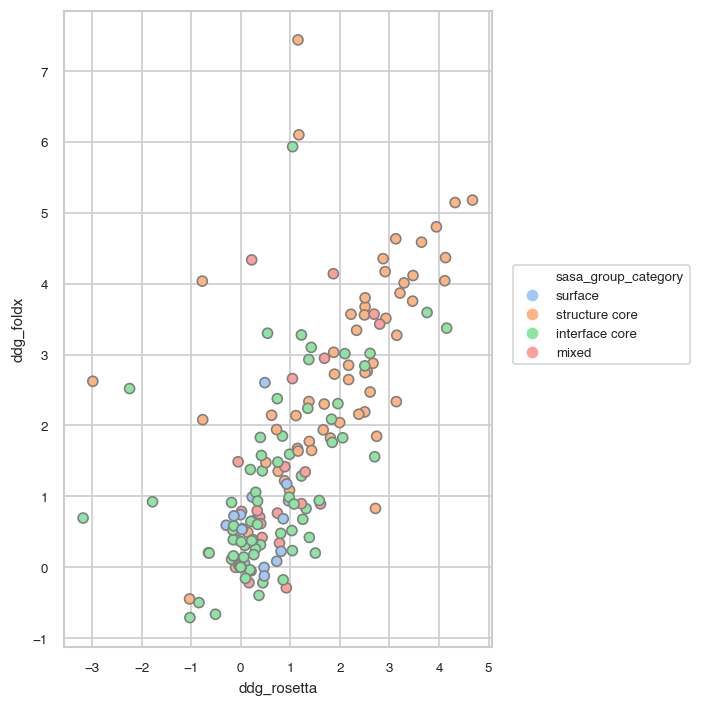

In [38]:
f, ax = plt.subplots(figsize=(6,6))

g = (pd.merge(df, df_consurf_burial)
     .pipe((sns.scatterplot, 'data'),
           x='ddg_rosetta', y='ddg_foldx',
           hue='sasa_group_category',
         linewidth=1, edgecolor='gray', ax=ax)
    )
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)
plt.tight_layout()


In [37]:
df_consurf_burial

,position,consurf_score,consurf,aa_to,score,region3,bin,sasa_group_category,score_bin,SEQ,exists_in_msa
0,1,-0.596,7,W,-5.999734,effector surface,STOP-like,surface,4,NaN,no
1,1,-0.596,7,F,-8.000000,effector surface,NaN,surface,4,M,yes
2,1,-0.596,7,Y,-3.593266,effector surface,intermediate,surface,3,NaN,no
3,1,-0.596,7,L,-4.190606,effector surface,STOP-like,surface,4,M,yes
4,1,-0.596,7,I,-5.481027,effector surface,STOP-like,surface,4,NaN,no
...,...,...,...,...,...,...,...,...,...,...,...
4375,219,-0.990,8,H,-0.353337,C-terminal surface,neutral,surface,2,NaN,no
4376,219,-0.990,8,R,-0.174941,C-terminal surface,neutral,surface,2,NaN,no
4377,219,-0.990,8,K,-1.345961,C-terminal surface,intermediate,surface,3,NaN,no
4378,219,-0.990,8,D,1.058344,C-terminal surface,beneficial,surface,1,NaN,no
